  # GLOBAL SETTINGS

In [1]:
# python peripherals
import random
import os
import sys
import math
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

# numpy
import numpy

# pandas
import pandas

# ipython
from IPython.display import display, HTML

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines

# pytorch
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader

# deep signature
from deep_signature.utils import utils
from deep_signature.data_generation.curve_generation import LevelCurvesGenerator
from deep_signature.data_manipulation import curve_processing
from deep_signature.nn.datasets import DeepSignatureTupletsDataset
from deep_signature.nn.networks import DeepSignatureArcLengthNet
from deep_signature.nn.networks import DeepSignatureCurvatureNet
from deep_signature.nn.trainers import ModelTrainer
from deep_signature.data_manipulation import curve_sampling
from deep_signature.data_manipulation import curve_processing
from deep_signature.linalg import euclidean_transform
from deep_signature.linalg import affine_transform

# common
from common import settings
from common import utils as common_utils

# notebooks
from notebooks.utils import utils as notebook_utils

  # IMPORT PACKAGES

In [2]:
# plt.style.use("dark_background")

transform_type = 'affine'

if transform_type == 'euclidean':
    level_curves_arclength_tuplets_dir_path = settings.level_curves_euclidean_arclength_tuplets_dir_path
    level_curves_arclength_tuplets_results_dir_path = settings.level_curves_euclidean_arclength_tuplets_results_dir_path
elif transform_type == 'equiaffine':
    level_curves_arclength_tuplets_dir_path = settings.level_curves_equiaffine_arclength_tuplets_dir_path
    level_curves_arclength_tuplets_results_dir_path = settings.level_curves_equiaffine_arclength_tuplets_results_dir_path
elif transform_type == 'affine':
    level_curves_arclength_tuplets_dir_path = settings.level_curves_affine_arclength_tuplets_dir_path
    level_curves_arclength_tuplets_results_dir_path = settings.level_curves_affine_arclength_tuplets_results_dir_path

if transform_type == 'euclidean':
    level_curves_curvature_tuplets_dir_path = settings.level_curves_euclidean_curvature_tuplets_dir_path
    level_curves_curvature_tuplets_results_dir_path = settings.level_curves_euclidean_curvature_tuplets_results_dir_path
elif transform_type == 'equiaffine':
    level_curves_curvature_tuplets_dir_path = settings.level_curves_equiaffine_curvature_tuplets_dir_path
    level_curves_curvature_tuplets_results_dir_path = settings.level_curves_equiaffine_curvature_tuplets_results_dir_path
elif transform_type == 'affine':
    level_curves_curvature_tuplets_dir_path = settings.level_curves_affine_curvature_tuplets_dir_path
    level_curves_curvature_tuplets_results_dir_path = settings.level_curves_affine_curvature_tuplets_results_dir_path

  # LEARNING CURVES

1.8498214629954401
1.8545526317459686


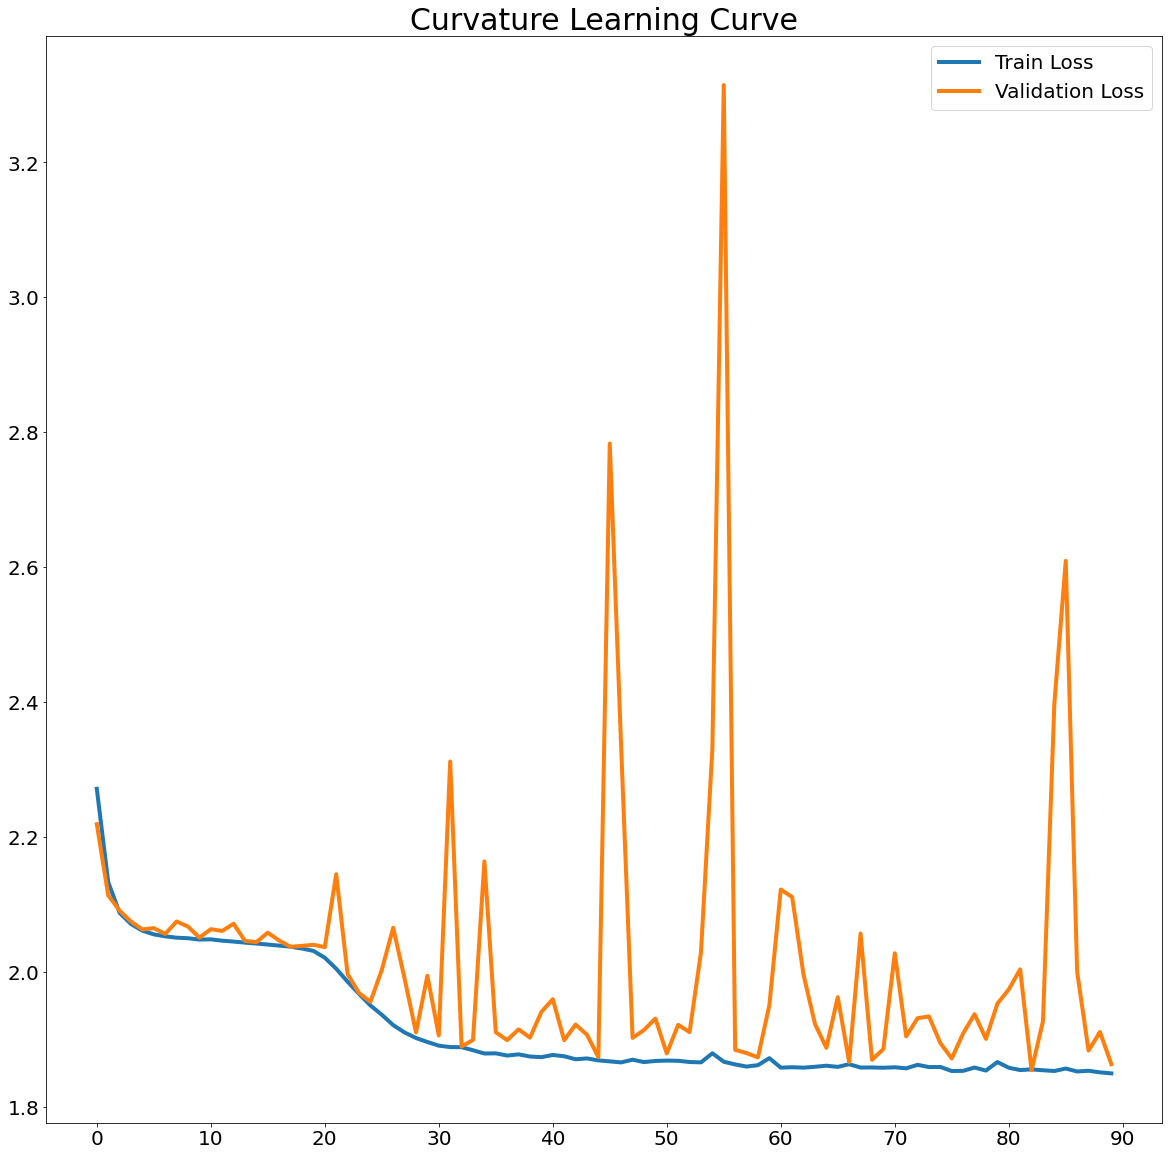

0.7123477691445039
0.7187178871546916


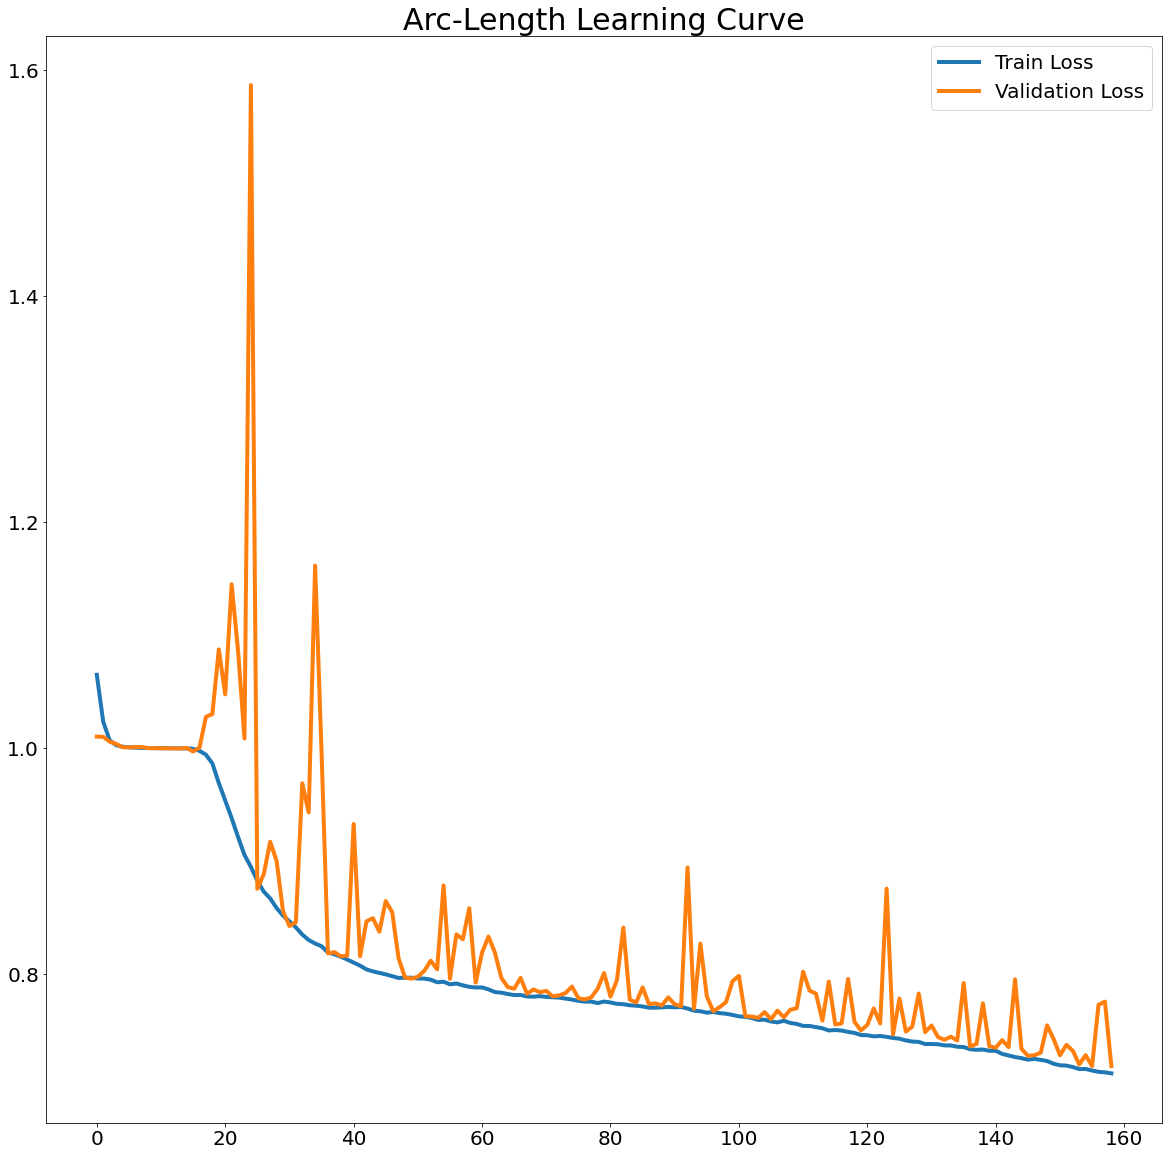

In [7]:
def plot_learning_curve(results_dir_path, title):
    latest_subdir = common_utils.get_latest_subdirectory(results_dir_path)
    results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()
    # results = numpy.load(f'C:/deep-signature-data/level-curves/results/tuplets/curvature/affine/2021-10-09-05-10-32/results.npy', allow_pickle=True).item()

    # epochs = results['epochs']
    # batch_size = results['batch_size']
    start_index = 0
    end_index = None
    train_loss_array = results['train_loss_array'][start_index:] if end_index is None else results['train_loss_array'][start_index:end_index]
    validation_loss_array = results['validation_loss_array'][start_index:] if end_index is None else results['validation_loss_array'][start_index:end_index]

    train_loss_array_no_nan = train_loss_array[~numpy.isnan(train_loss_array)]
    validation_loss_array_no_nan = validation_loss_array[~numpy.isnan(validation_loss_array)]

    epochs_list = numpy.array(range(len(train_loss_array)))

    fig, ax = plt.subplots(1, 1, figsize=(20,20))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(20)

    ax.plot(epochs_list, train_loss_array, label='Train Loss', linewidth=4.0)
    ax.plot(epochs_list, validation_loss_array, label='Validation Loss', linewidth=4.0)
    ax.set_title(title, fontsize=30)

    plt.legend(fontsize=20, title_fontsize=20)

    print(numpy.min(train_loss_array_no_nan))
    print(numpy.min(validation_loss_array_no_nan))

    plt.show()

plot_learning_curve(level_curves_curvature_tuplets_results_dir_path, 'Curvature Learning Curve')
plot_learning_curve(level_curves_arclength_tuplets_results_dir_path, 'Arc-Length Learning Curve')

  # CURVE RECORDS EXTRACTION

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# constants
true_arclength_colors = ['#FF8C00', '#444444']
predicted_arclength_colors = ['#AA0000', '#0000AA']
sample_colors = ['#FF0000', '#0000FF']
curve_colors = ['#FF0000', '#0000FF', '#FF9D11']
limit = 1
factor_extraction_limit = -1
# step = settings.arclength_default_supporting_points_count - 1
step = 40
comparison_curves_count = 2
sampling_ratio = 0.7
anchors_ratio = 1

device = torch.device('cuda')

# if we're in the equiaffine case, snap 'step' to the closest mutiple of 3 (from above)
# if transform_type == "equiaffine":
#     step = int(3 * numpy.ceil(step / 3))

# package settings
torch.set_default_dtype(torch.float64)
# numpy.random.seed(20)
numpy.random.seed(40)
# numpy.random.seed(90)
# numpy.random.seed(120)

# create models
arclength_model = DeepSignatureArcLengthNet(sample_points=settings.arclength_default_supporting_points_count, transformation_group_type=transform_type).cuda()
curvature_model = DeepSignatureCurvatureNet(sample_points=settings.curvature_default_sample_points_count).cuda()

# load arclength model state
latest_subdir = common_utils.get_latest_subdirectory(level_curves_arclength_tuplets_results_dir_path)
results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()
arclength_model.load_state_dict(torch.load(results['model_file_path'], map_location=device))
arclength_model.eval()

# load curvature model state
latest_subdir = common_utils.get_latest_subdirectory(level_curves_curvature_tuplets_results_dir_path)
# latest_subdir = 'C:/deep-signature-data/level-curves/results/tuplets/curvature/affine/2021-10-09-05-10-32'
results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()
curvature_model.load_state_dict(torch.load(results['model_file_path'], map_location=device))
curvature_model.eval()

# load curves (+ shuffle)
# curves_train = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
# curves_validation = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_validation)
curves_full = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_test)
curves = []
for curve in curves_full:
    if 800 < curve.shape[0] < 1200:
        curves.append(curve)

print(len(curves))

# print(len(curves_train))
# print(len(curves_validation))
# print(len(curves_test))

numpy.random.shuffle(curves)
curves_limited = curves[:limit]
factor_extraction_curves = curves[factor_extraction_limit:]

# create color map
color_map = plt.get_cmap('rainbow', limit)

# generate curve records
curve_records = notebook_utils.generate_curve_records(
    arclength_model=arclength_model,
    curvature_model=curvature_model,
    curves=curves_limited,
    factor_extraction_curves=factor_extraction_curves,
    transform_type=transform_type,
    comparison_curves_count=comparison_curves_count,
    sampling_ratio=sampling_ratio,
    anchors_ratio=anchors_ratio,
    step=step,
    neighborhood_supporting_points_count=settings.curvature_default_supporting_points_count,
    section_supporting_points_count=settings.arclength_default_supporting_points_count)

  # EVALUATE CURVATURE

In [ ]:
notebook_utils.plot_curve_curvature_comparisons(
    curve_records=curve_records, 
    curve_colors=curve_colors,
    sampling_ratio=sampling_ratio,
    transformation_group_type=transform_type,
    plot_to_screen=True)

  # EVALUATE ARC-LENGTH

In [ ]:
# notebook_utils.plot_curve_arclength_records(
#     curve_records=curve_records, 
#     true_arclength_colors=true_arclength_colors,
#     predicted_arclength_colors=predicted_arclength_colors,
#     curve_colors=curve_colors)

  # EVALUATE SIGNATURES

In [ ]:
# notebook_utils.plot_curve_signature_comparisons(
#     curve_records=curve_records, 
#     predicted_signature_colors=predicted_arclength_colors,
#     true_signature_colors=true_arclength_colors,
#     sample_colors=sample_colors)

# EVALUATE SIGNATURE METRICS

In [ ]:
# metrics = notebook_utils.calculate_signature_metrics(curve_records=curve_records)
# print(metrics)